# Guia de Análise Exploratória de Dados com Python e Linguagem SQL 

Análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de Dados SQLite. Usaremos dados reais disponíveis publicamente, dados sobre filmes no IMDB.

Ao aplicar Análise Exploratória de Dados vamos responder a estas 10 perguntas:

1- Quais São as Categorias de Filmes Mais Comuns no IMDB?

2- Qual o Número de Títulos Por Gênero?

3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

7- Qual a Relação Entre Duração e Gênero?

8- Qual o Número de Filmes Produzidos Por País?

9- Quais São os Top 10 Melhores Filmes?

10- Quais São os Top 10 Piores Filmes?

In [1]:
#Versão da Linguagem Python
from platform import python_version
print('Versão da linguagem Python usada neste Jupyter Notebook: ', python_version())

Versão da linguagem Python usada neste Jupyter Notebook:  3.9.12


In [2]:
#Instala o pacote
!pip install -q imdb-sqlite

Agora executamos o pacote para download dos datasets

In [4]:
#instala o Pacote
!pip install -q pycountry

In [6]:
#Importações para o projeto
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

## Caregando os Dados

Primeiro temos que baixar os dados!

In [7]:
%%time
!imdb-sqlite

CPU times: total: 0 ns
Wall time: 424 ms


2022-09-13 10:55:16,397 DB already exists: (imdb.db). Refusing to modify. Exiting


In [8]:
#Conecta no banco de dados
conn = sqlite3.connect("imdb.db")

In [9]:
#Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type='table'", conn)

In [10]:
#Tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [11]:
#Visualiza o resultado
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [12]:
#Convertendo o dataframe em uma lista
tabelas = tabelas ["Table_Name"].values.tolist()

In [13]:
#Percorrendo a lista de tabelas no banco de dados e extraindo o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




## Analise Exploratória dos Dados:

## 1- Quais são as categorias de filmes mais comuns no IMDB?

In [15]:
#Cria a consulta SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [16]:
#Extrai o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [17]:
#Visualiza o resultado
display(resultado1)

,type,COUNT
0,movie,620963
1,short,888843
2,tvEpisode,6949671
3,tvMiniSeries,45063
4,tvMovie,137540
5,tvPilot,2
6,tvSeries,230893
7,tvShort,10664
8,tvSpecial,38245
9,video,265154


In [18]:
#Vamos calcular o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [19]:
#Visualiza o resultado
display(resultado1)

,type,COUNT,percentual
0,movie,620963,6.735550
1,short,888843,9.641229
2,tvEpisode,6949671,75.382680
3,tvMiniSeries,45063,0.488796
4,tvMovie,137540,1.491888
5,tvPilot,2,0.000022
6,tvSeries,230893,2.504483
7,tvShort,10664,0.115672
8,tvSpecial,38245,0.414841
9,video,265154,2.876110


In [20]:
#Criando um gráfico com 4 categorias:
# 3 categorias com mais títulos e 1 categoria com todo restante

#Cria um dicionário vazio
others = {}

#Filtra o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

#Grava o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

#Ajusta o nome
others['type'] = 'others'

In [21]:
#Visualiza
others

{'COUNT': 759711, 'percentual': 8.2405413578723, 'type': 'others'}

In [22]:
#Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [23]:
#Append com o datafram de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [24]:
#Ordena o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [25]:
#Vizualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6949671,75.382680
1,short,888843,9.641229
3,others,759711,8.240541
0,movie,620963,6.735550


In [26]:
#Ajusta os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1["percentual"][i],2)) +'%'+']' for i in resultado1.index]

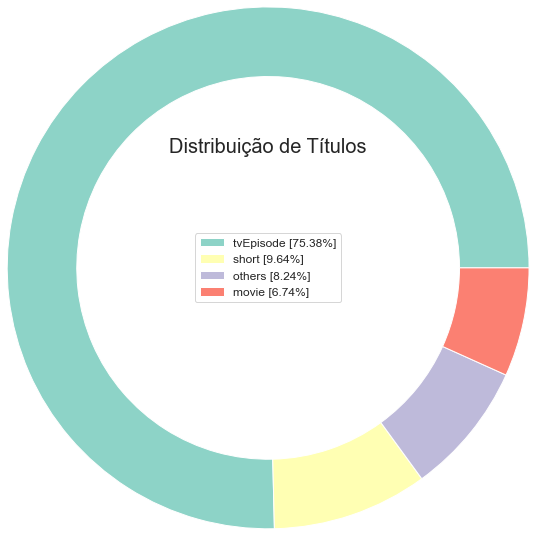

In [27]:
#Plot

#Mapa de cores
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

#Cria a figura
f = plt.figure()

#Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict (width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize': 20, 'fontweight': 20})
plt.show()

## 2- Qual o número de títulos por gênero? 

A resposta será entregue em percentual apos o cálculo de número de filmes por gênero

In [28]:
#Cria a consulta SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres '''

In [29]:
#Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [30]:
#Visualiza o resultado
display(resultado2)

,genres,COUNT(*)
0,Action,14183
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",9
...,...,...
1461,"Thriller,Western",43
1462,War,1313
1463,"War,Western",14
1464,Western,5145


In [31]:
#Converte as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [32]:
#Remove valores NA (ausentes)
temp = resultado2['genres'].dropna()

In [33]:
#Vamos criar um vetor usando expressão regular para filtrar as strings
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [35]:

type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [36]:
#Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [37]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [38]:
#Retorna gêneros únicos
generos_unicos = vetor.get_feature_names()

In [39]:
#Cria o dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [40]:
#Visualiza
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466 entries, 0 to 1465
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1466 non-null   int64
 1   adult        1466 non-null   int64
 2   adventure    1466 non-null   int64
 3   animation    1466 non-null   int64
 4   biography    1466 non-null   int64
 5   comedy       1466 non-null   int64
 6   crime        1466 non-null   int64
 7   documentary  1466 non-null   int64
 8   drama        1466 non-null   int64
 9   family       1466 non-null   int64
 10  fantasy      1466 non-null   int64
 11  film-noir    1466 non-null   int64
 12  game-show    1466 non-null   int64
 13  history      1466 non-null   int64
 14  horror       1466 non-null   int64
 15  music        1466 non-null   int64
 16  musical      1466 non-null   int64
 17  mystery      1466 non-null   int64
 18  n            1466 non-null   int64
 19  news         1466 non-null   int64
 20  reality-

In [41]:
#Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [42]:
#Calcula o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [43]:
#Visualiza
generos_percentual.head(10)

drama          17.939973
comedy         16.984993
documentary    15.893588
adventure      14.802183
action         14.392906
romance        13.301501
crime          12.960437
mystery        12.346521
thriller       12.278308
horror         12.278308
dtype: float64

In [ ]:
#Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = 'terrain')
plt.ylabel('Gênero')
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

## 3- Qual a mediana de avaliação dos filmes por gênero?

In [45]:
#Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type = 'movie' 
            '''

In [46]:
#Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [47]:
#Visualiza
resultado3

,rating,genres
0,5.2,Romance
1,3.7,\N
2,6.0,"Action,Adventure,Biography"
3,4.0,Drama
4,4.1,Drama
...,...,...
282121,5.8,Thriller
282122,6.4,"Drama,History"
282123,3.8,"Adventure,History,War"
282124,8.3,Drama


In [48]:
#Criando função para retornar gêneros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [49]:
#Aplica a função
generos_unicos = retorna_generos(resultado3)

In [50]:
#Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [51]:
#Cria listas vazias
genero_counts = []
genero_ratings = []

In [52]:
#Loop
for item in generos_unicos:
    
    #Retorna a contagem por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    #Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [53]:
#Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [54]:
#Visualiza
df_genero_ratings.head(20)

,genres,count,rating
0,action,29235,5.8
1,adult,4405,5.8
2,adventure,17683,6.0
3,animation,4838,6.6
4,biography,8623,7.0
5,comedy,69628,6.0
6,crime,24138,6.1
7,documentary,42465,7.3
8,drama,124971,6.3
9,family,10876,6.3


In [55]:
#Drop do índice 18 (news)
#Não queremos essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [56]:
#Ordena o resultado
df_genero_ratings = df_genero_ratings.sort_values (by = 'rating', ascending = False)

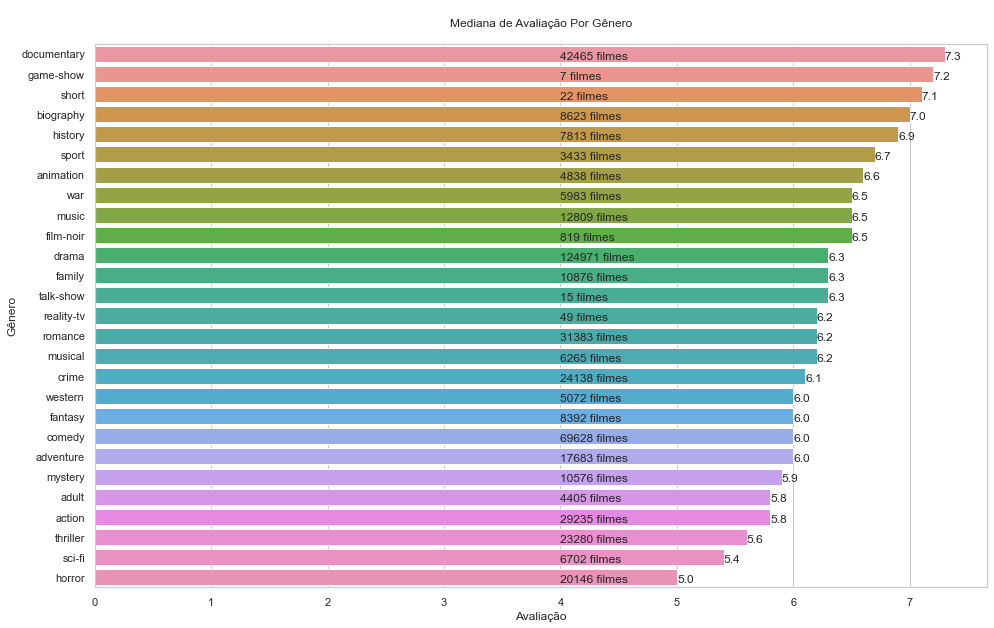

In [57]:
#Plot

#Figura
plt.figure(figsize = (16,10))

#Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

#Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0,
             i + 0.25,
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]], 2))
    
plt.ylabel('Gênero')
plt.xlabel('Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

## 4- Qual a mediana de avaliação dos filmes em relação ao ano de estréia? 

In [58]:
#consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type = 'movie' 
            ORDER BY premiered
            '''

In [59]:
#Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [60]:
display(resultado4)

,Rating,premiered
0,5.2,1894
1,6.2,1896
2,4.4,1897
3,3.9,1899
4,3.2,1899
...,...,...
282121,8.1,2022
282122,6.8,2022
282123,5.3,2022
282124,3.9,2022


In [61]:
#Calculando a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [62]:
type(ratings)

list

In [63]:
ratings[1:10]

[6.2, 4.4, 3.55, 5.35, 4.1, 3.4, 4.0, 5.3, 3.8]

In [65]:
#Lista de anos
anos = list(set(resultado4['premiered']))

In [66]:
anos[1:10]

[1896, 1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905]

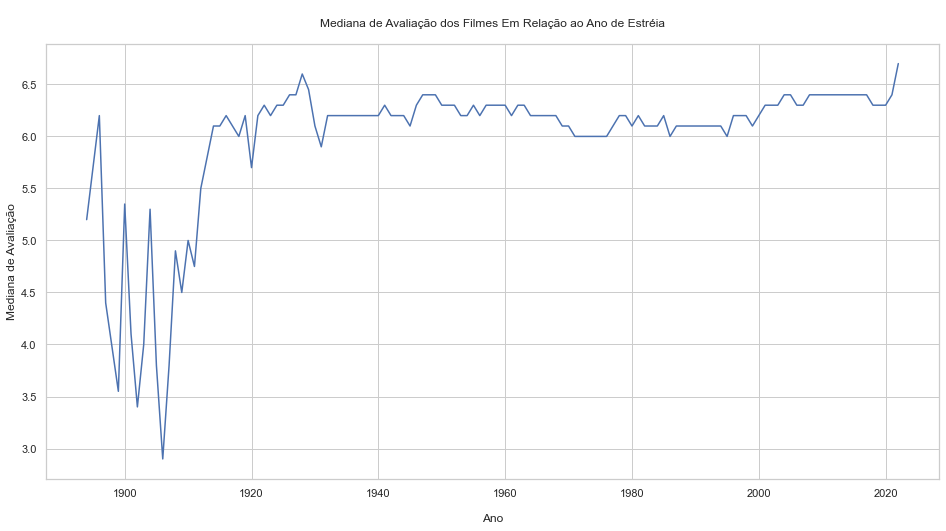

In [67]:
#Plot

plt.figure(figsize = (16,8))
plt.plot(anos,ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

## 5- Qual o número de filmes avaliados por gênero em relação ao ano de estréia? 

Para a resposta será listado o top 5

In [68]:
#Consulta SQL
consulta5 = '''SELECT genres FROM titles'''

In [69]:
#Resultado
resultado5 = pd.read_sql_query(consulta5, conn)

In [70]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9219183,"Action,Drama,Family"
9219184,"Action,Drama,Family"
9219185,"Action,Drama,Family"
9219186,Short


In [71]:
#Retorna gêneros únicos
generos_unicos = retorna_generos(resultado5)

In [72]:
#Visualiza o resultado
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [73]:
#Realizando a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM titles WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [76]:
# Prepara o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [77]:
#Calcula as top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

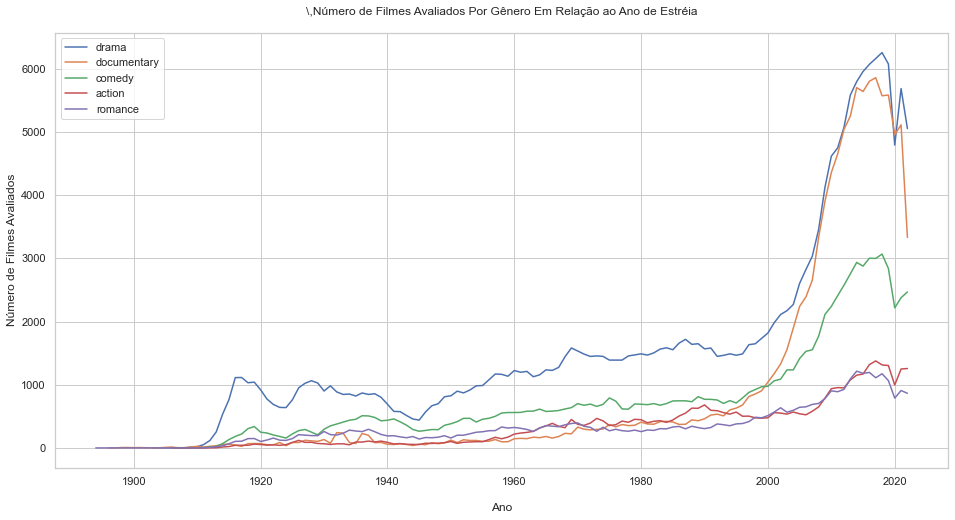

In [78]:
#Plot

#Figura
plt.figure(figsize = (16,8))

#Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])
    
plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\,Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

## 6- Qual o filme com maior tempo de duração? Calcule os percentis.

Percentis e filme mais longo da história.

In [79]:
#Consulta SQL
consulta6 = '''
            SELECT runtime_minutes Runtime
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            '''

In [80]:
#Resultado
resultado6 = pd.read_sql_query(consulta6, conn)

In [81]:
display(resultado6)

,Runtime
0,45
1,100
2,70
3,90
4,120
...,...
391862,123
391863,57
391864,100
391865,116


In [82]:
#Loop para cálculo dos percentis
for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 54.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 57.0
11 percentil da duração (runtime) é: 58.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 62.0
17 percentil da duração (runtime) é: 64.0
18 percentil da duração (runtime) é: 65.0
19 percentil da duração (runtime) é: 67.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 71.0
24 

In [83]:
#Refazendo a consulta e retornando o filme com maior duração
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles
            WHERE type='movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            '''

In [84]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [85]:
resultado6

,Runtime,primary_title
0,51420,Logistics


## 7- Qual a relação entre duração e gênero? 

In [86]:
#Consulta SQL
consulta7 = '''
            SELECT AVG (runtime_minutes) Runtime, genres
            FROM titles
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            '''

In [87]:
#Resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [88]:
#Retorna gêneros únicos
generos_unicos = retorna_generos(resultado7)

In [89]:
#Calculo de duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM titles WHERE genres LIKE'+ '\''+'%'+item+'%'+ '\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))
    

In [90]:
#Prepara o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [91]:
#Remove o índice 18(news)
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [92]:
#Ordena os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

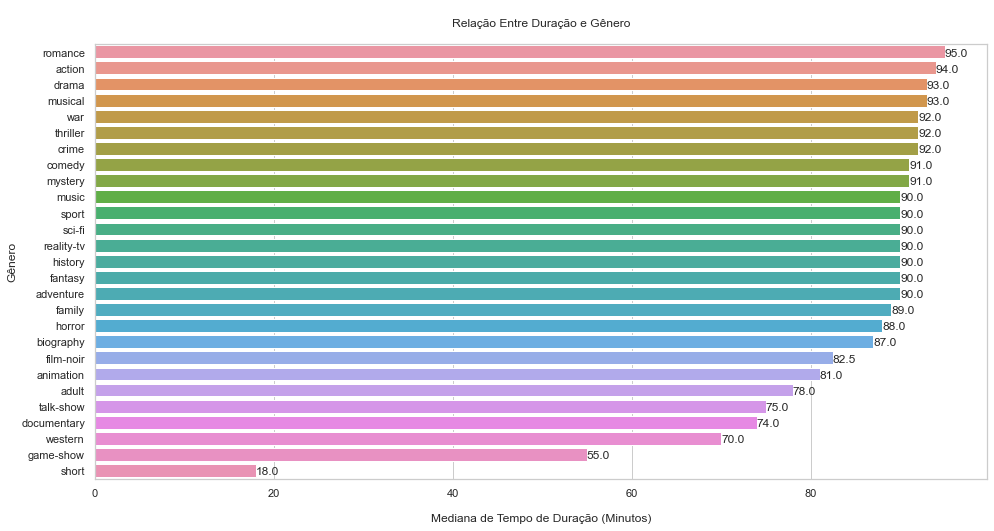

In [93]:
#Plot

#Tamanho da figura
plt.figure(figsize = (16,8))

#Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

#Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
            i+ 0.25,
            round(df_genero_runtime['runtime'][df_genero_runtime.index[i]], 2))
    
plt.ylabel('Gênero')
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

## 8- Qual o número de filmes produzidos por país? 

In [94]:
#Consulta SQL
consulta8 = '''
             SELECT region, COUNT (*) Number_of_movies FROM
             akas JOIN titles ON
             akas.title_id = titles.title_id
             WHERE region != 'None'
             AND type = \'movie\'
             GROUP BY region
             ''' 

In [95]:
#Resultado
resultado8 = pd.read_sql_query(consulta8, conn)

In [96]:
display(resultado8)

,region,Number_of_movies
0,AD,21
1,AE,7879
2,AF,110
3,AG,12
4,AL,1301
...,...,...
230,YUCS,153
231,ZA,8040
232,ZM,18
233,ZRCD,2


In [97]:
#Shape
resultado8.shape

(235, 2)

In [98]:
#Número de linhas
resultado8.shape[0]

235

In [99]:
#Listas auxiliares
nomes_paises = []
contagem = []

In [100]:
#Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
#Poderia ser range(232), mas perde-se a função de acordo com a atualização das informações.
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except:
        continue

In [101]:
#Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [102]:
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [103]:
# Visualiza
df_filmes_paises.head(10)

,country,Movie_Count
200,United States,317129
66,United Kingdom,161318
97,Japan,93552
90,India,86419
64,France,86245
32,Canada,81675
48,Germany,72696
59,Spain,67294
94,Italy,66658
26,Brazil,66571


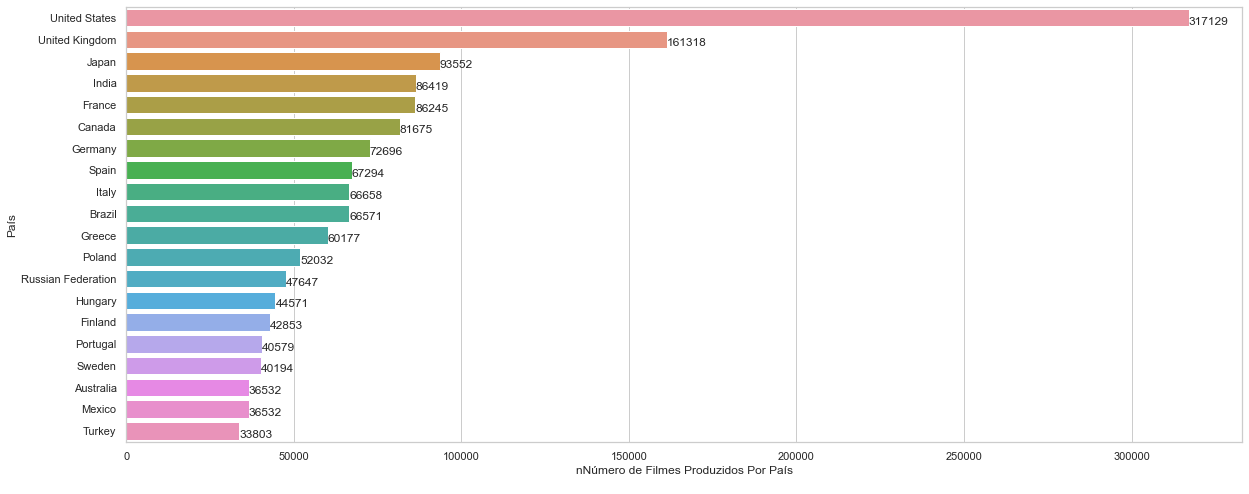

In [104]:
#Plot

#Figura
plt.figure(figsize = (20,8))

#Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

#Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
            i+ 0.30,
            round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]], 2))
    
plt.ylabel('País')
plt.xlabel('nNúmero de Filmes Produzidos Por País\n')
plt.show()

## 9- Top 10 dos melhores filmes

Melhores filmes com mais de 25 mil votos

In [105]:
#Consulta SQL
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [106]:
#Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [107]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Godfather,"Crime,Drama",9.2
2,The Chaos Class,"Comedy,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
4,12 Angry Men,"Crime,Drama",9.0
5,The Godfather Part II,"Crime,Drama",9.0
6,Schindler's List,"Biography,Drama,History",9.0
7,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
8,The Dark Knight,"Action,Crime,Drama",9.0
9,Mirror Game,"Crime,Mystery,Thriller",9.0


## 10- Top 10 dos piores filmes

In [108]:
# Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

In [109]:
# Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [110]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Crime,Drama,History",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
